In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from Corrfunc.theory.DD import DD
from Corrfunc.io import read_catalog
from Corrfunc.utils import convert_3d_counts_to_cf

In [3]:
halos = {}
halos['lcdm'] = np.load('../Trial_PP_halo_catalog_2048Mpc_n4096_M13.npy')
halos['m26'] = np.load('../Trial_PP_halo_catalog_2048Mpc_n4096_1_26_10_M13.npy')
halos['m25'] = np.load('../Trial_PP_halo_catalog_2048Mpc_n4096_1_25_10_M13.npy')
halos['m24'] = np.load('../Trial_PP_halo_catalog_2048Mpc_n4096_1_24_10_M13.npy')
halos['m23'] = np.load('../Trial_PP_halo_catalog_2048Mpc_n4096_1_23_10_M13.npy')

voids = {}
voids['lcdm'] = np.loadtxt('../2048Mpc_n4096_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m26'] = np.loadtxt('../2048Mpc_n4096_1_26_10_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m25'] = np.loadtxt('../2048Mpc_n4096_1_25_10_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m24'] = np.loadtxt('../2048Mpc_n4096_1_24_10_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m23'] = np.loadtxt('../2048Mpc_n4096_1_23_10_M13zobov-Voids_cat.txt', dtype=np.float32)    

hx = {}
hy = {}
hz = {}

vx = {}
vy = {}
vz = {}
vR = {}
vdelmin = {}
vdelavg = {}

for K in halos.keys():
    hx[K], hy[K], hz[K] = halos[K][:, :3].T + 1024 * .68
    vx[K] = (voids[K][:,1]-1024*.68)%(2048*.68)
    vy[K] = (voids[K][:,2]-1024*.68)%(2048*.68)
    vz[K] = (voids[K][:,3]-1024*.68)%(2048*.68)
    vR[K] = voids[K][:,4]
    vdelmin[K] = voids[K][:,5]
    vdelavg[K] = voids[K][:,6]

In [4]:
# Create weights matrix for the bootstrap eval

def normalized_weights(N):
    w = np.random.uniform(0, 1, N**3)
    return N**3 * w / np.sum(w)

In [5]:
def calc_weights_subvolumes(cat_x, cat_y, cat_z):
    '''
    '''
    
    N = 5 # 5^3 subvolumes
    
    # subvolume edges in x, y, z
    xed = np.linspace(0, 2048*.68, N+1)
    yed = np.linspace(0, 2048*.68, N+1)
    zed = np.linspace(0, 2048*.68, N+1)
    
    # weights of subvolumes
    wsubvol = normalized_weights(N)
    
    # weights of objects within subvolumes
    wobj = np.zeros(len(cat_x))
    
    M = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                indx = (cat_x <= xed[i+1]) & (cat_x > xed[i])
                indy = (cat_y <= yed[j+1]) & (cat_y > yed[j])
                indz = (cat_z <= zed[k+1]) & (cat_z > zed[k])
                ind = indx * indy * indz
                
                wobj[ind] = wsubvol[M]
                
                M += 1
                
    return wobj

In [6]:
calc_weights_subvolumes(hx['lcdm'], hy['lcdm'], hz['lcdm'])

array([2.04582924, 2.04582924, 2.04582924, ..., 0.28543932, 0.28543932,
       0.28543932])

In [7]:
def compute_gv_corr(X, Y, Z, X2, Y2, Z2):
    # Setup the bins
    nbins = 30
    bins = np.linspace(1, 150.0, nbins + 1) # note that +1 to nbins
    
    boxsize =  2048 * .68
    nthreads = 8
    
    ND1 = len(X)
    ND2 = len(X2)
    
    rand_N1 = 3*ND1
    rand_X1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
    rand_Y1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
    rand_Z1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
    
    # Compute weights
    wD1 = calc_weights_subvolumes(X, Y, Z)
    wD2 = calc_weights_subvolumes(X2, Y2, Z2)
    #wR = calc_weights_subvolumes(rand_X1, rand_Y1, rand_Z1)
    
    # Auto pair counts in DD
    autocorr=1
    D1D1_counts = DD(autocorr, nthreads, bins, X, Y, Z,
                  periodic=True, verbose=False, boxsize=boxsize, weights1=wD1)

    autocorr=1
    D2D2_counts = DD(autocorr, nthreads, bins, X2, Y2, Z2,
                  periodic=True, verbose=False, boxsize=boxsize, weights1=wD2)

    # Cross pair counts in DD
    autocorr=0
    D1D2_counts = DD(autocorr, nthreads, bins, X, Y, Z, X2=X2, Y2=Y2, Z2=Z2,
                  periodic=True, verbose=False, boxsize=boxsize, weights1=wD1, weights2=wD2)

    # Cross pair counts in DR
    autocorr=0
    D1R_counts = DD(autocorr, nthreads, bins, X, Y, Z,
                  X2=rand_X1, Y2=rand_Y1, Z2=rand_Z1,
                  periodic=True, verbose=False, boxsize=boxsize, weights1=wD1,)

    # Cross pair counts in DR
    autocorr=0
    D2R_counts = DD(autocorr, nthreads, bins, X2, Y2, Z2,
                  X2=rand_X1, Y2=rand_Y1, Z2=rand_Z1,
                  periodic=True, verbose=False, boxsize=boxsize, weights1=wD2)

    # Auto pairs counts in RR
    autocorr=1
    RR_counts = DD(autocorr, nthreads, bins, rand_X1, rand_Y1, rand_Z1,
                   periodic=True, verbose=False, boxsize=boxsize)

    
    cfgv = convert_3d_counts_to_cf(ND1, ND2, rand_N1, rand_N1,
                                D1D2_counts, D1R_counts,
                                D2R_counts, RR_counts)
    
    return cfgv

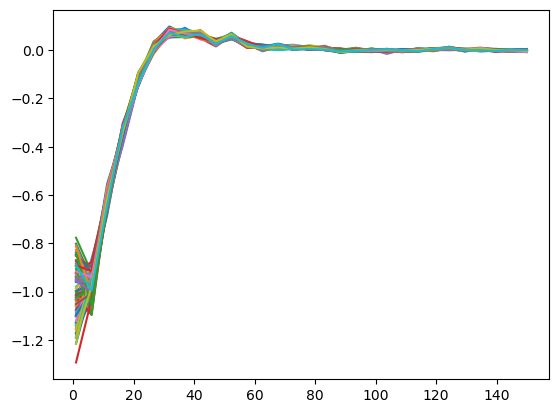

In [8]:
#compute_cfs('lcdm')
xis = []
for i in range(100):
    xi = compute_gv_corr(hx['lcdm'][::100], hy['lcdm'][::100], hz['lcdm'][::100], 
                    vx['lcdm'], vy['lcdm'], vz['lcdm'])
    xis.append(xi)
plt.plot(np.linspace(1, 150.0, 30), np.array(xis).T)

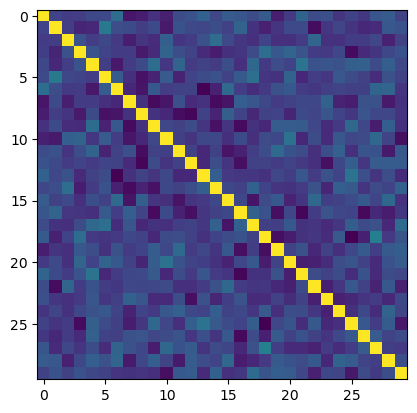

In [9]:
plt.imshow(np.corrcoef(np.array(xis).T))

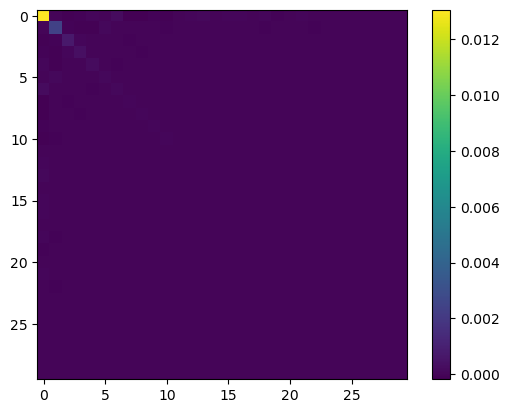

In [10]:
plt.imshow(np.cov(np.array(xis).T))
plt.colorbar()

[27.01380958 25.38696715  1.15502885  5.64321425]


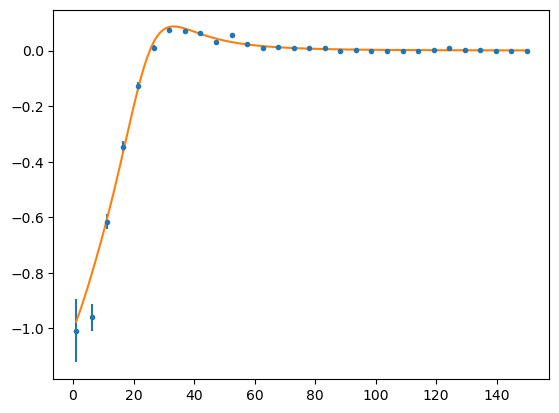

In [11]:
# fitting

from scipy.optimize import curve_fit

def gv_model(r, rv, rs, alpha, beta): 
    #alpha = -2 * (rs/rv-2)
    #if rs/rv < 0.91:
    #    beta = 17.5 * rs/rv - 6.5
    #else:
    #    beta = -9.8* rs/rv + 18.4
    
    out = -1 * (1-abs(r/rs)**alpha) / (1+abs(r/rv)**beta)
    
    if np.all(np.isfinite(out)):
        return out
    else:
        return np.zeros(len(out))

fit = curve_fit(gv_model, np.linspace(1, 150.0, 30), np.mean(np.array(xis), axis=0),
                sigma=np.cov(np.array(xis).T),
                maxfev=100000, p0=[ 12, 10, 2.2, 9.8])[0]

print(fit)

plt.errorbar(np.linspace(1, 150.0, 30), np.mean(np.array(xis), axis=0), 
             yerr=np.diag(np.cov(np.array(xis).T))**.5, fmt='.')
plt.plot(np.linspace(1, 150.0, 300), gv_model(np.linspace(1, 150.0, 300), *fit))

In [12]:
def bootstrap_cov():
    return

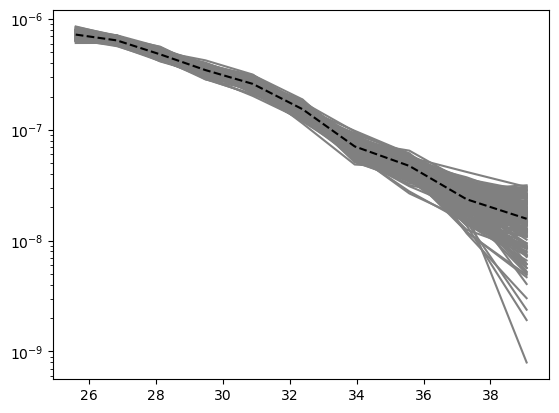

In [79]:
# void size function

vsfs = []

sel = np.loadtxt('test_new_radii_lcdm_rejected_voids.dat') == 0
clean_voids = np.loadtxt('test_new_radii_lcdm.dat')

for _ in range(200):
    ws = calc_weights_subvolumes(vx['lcdm'][sel], vy['lcdm'][sel], vz['lcdm'][sel])
    #ws /= np.sum(ws)

    bin_edges    = np.geomspace(25, 40, 11)
    bin_cens     = (bin_edges[:-1] + bin_edges[1:]) / 2
    hist_void    = np.histogram(clean_voids, bins=bin_edges, weights=ws)
    n_of_R_void  = np.cumsum(hist_void[0]/(2048*.68)**3)
    dn_dlnR_void = np.gradient(n_of_R_void, np.log(bin_cens))

    plt.semilogy(bin_cens, dn_dlnR_void, '-', c='grey')
    vsfs.append(dn_dlnR_void)
    
bin_edges    = np.geomspace(25, 40, 11)
bin_cens     = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_void    = np.histogram(clean_voids, bins=bin_edges)
n_of_R_void  = np.cumsum(hist_void[0]/(2048*.68)**3)
dn_dlnR_void = np.gradient(n_of_R_void, np.log(bin_cens))

plt.semilogy(bin_cens, dn_dlnR_void, '--', c='k')

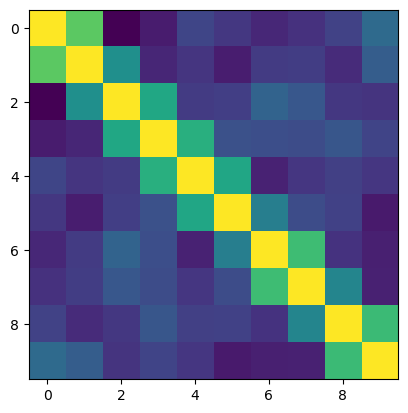

In [80]:
plt.imshow(np.corrcoef(np.array(vsfs).T))

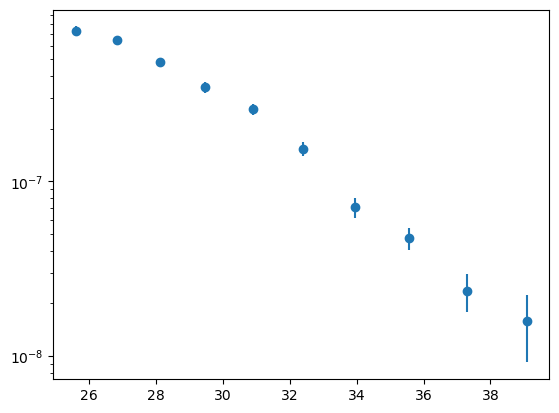

In [81]:
bin_edges    = np.geomspace(25, 40, 11)
bin_cens     = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_void    = np.histogram(clean_voids, bins=bin_edges)
n_of_R_void  = np.cumsum(hist_void[0]/(2048*.68)**3)
dn_dlnR_void = np.gradient(n_of_R_void, np.log(bin_cens))
plt.errorbar(bin_cens, dn_dlnR_void, yerr=np.diag(np.cov(np.array(vsfs).T))**.5, fmt='o')
plt.yscale('log')